# Task 3: Feature Extractor
## Extract FaceNet embeddings and store in SQLite database

### 1. Import Libraries

In [31]:
import cv2
import numpy as np
from pathlib import Path
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Add src to path
sys.path.insert(0, str(Path('..').resolve()))
from src.embedding import FaceEmbedder, EmbeddingDatabase

print("Libraries imported successfully!")

Libraries imported successfully!


### 2. Setup Paths

In [32]:
# Define paths
BASE_PATH = Path('..').resolve()
GALLERY_ALIGNED_PATH = BASE_PATH / 'data' / 'gallery_aligned'
DB_PATH = BASE_PATH / 'data' / 'embeddings.db'

print(f"Base path: {BASE_PATH}")
print(f"Gallery path: {GALLERY_ALIGNED_PATH}")
print(f"Database path: {DB_PATH}")
print(f"Gallery path exists: {GALLERY_ALIGNED_PATH.exists()}")

# List gallery images
gallery_persons = sorted([d for d in GALLERY_ALIGNED_PATH.iterdir() if d.is_dir()])
print(f"\nIdentities in gallery: {len(gallery_persons)}")

# Count total images
total_images = 0
for person_dir in gallery_persons:
    images = list(person_dir.glob('*.jpg')) + list(person_dir.glob('*.png'))
    total_images += len(images)

print(f"Total images to process: {total_images}")

Base path: C:\SAHIL\assignment
Gallery path: C:\SAHIL\assignment\data\gallery_aligned
Database path: C:\SAHIL\assignment\data\embeddings.db
Gallery path exists: True

Identities in gallery: 20
Total images to process: 78


### 3. Initialize Embedder and Database

In [33]:
# Initialize embedder
embedder = FaceEmbedder(model_name='vggface2')
print("Face embedder initialized!")

# Initialize database
db = EmbeddingDatabase(str(DB_PATH))
print(f"Database initialized at: {DB_PATH}")

# Show initial stats
stats = db.get_db_stats()
print(f"\nDatabase stats: {stats}")

Face embedder initialized!
Database initialized at: C:\SAHIL\assignment\data\embeddings.db

Database stats: {'total_identities': 21, 'total_embeddings': 80, 'db_path': 'C:\\SAHIL\\assignment\\data\\embeddings.db', 'db_size_mb': 0.3515625}


### 4. Extract Embeddings from Gallery

In [34]:
# Extract embeddings for all gallery images
extraction_results = []
failed_images = []

print(f"Extracting embeddings from {total_images} images...\n")

for person_dir in tqdm(gallery_persons, desc="Processing identities"):
    identity_name = person_dir.name
    images = sorted(list(person_dir.glob('*.jpg')) + list(person_dir.glob('*.png')))
    
    for img_path in images:
        try:
            # Load image
            img = cv2.imread(str(img_path))
            if img is None:
                failed_images.append(str(img_path))
                continue
            
            # Extract embedding
            embedding = embedder.extract_embedding(img)
            
            # Store in database
            db.add_embedding(identity_name, img_path, embedding)
            
            extraction_results.append({
                'identity': identity_name,
                'image_path': str(img_path),
                'embedding_dim': len(embedding),
                'status': 'success'
            })
        
        except Exception as e:
            failed_images.append(str(img_path))
            extraction_results.append({
                'identity': identity_name,
                'image_path': str(img_path),
                'error': str(e),
                'status': 'failed'
            })

print(f"\n✓ Extraction complete!")
print(f"  Successful: {len([r for r in extraction_results if r['status'] == 'success'])}")
print(f"  Failed: {len([r for r in extraction_results if r['status'] == 'failed'])}")

Extracting embeddings from 78 images...



Processing identities: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


✓ Extraction complete!
  Successful: 0
  Failed: 78


### 5. Database Statistics

In [35]:
# Get updated stats
stats = db.get_db_stats()
print("=" * 60)
print("DATABASE STATISTICS")
print("=" * 60)
print(f"Total Identities: {stats['total_identities']}")
print(f"Total Embeddings: {stats['total_embeddings']}")
print(f"Database Size: {stats['db_size_mb']:.2f} MB")
print(f"Database Path: {stats['db_path']}")
print("=" * 60)

# Get identities with counts
identities = db.get_identities()
df_identities = pd.DataFrame(identities)

print(f"\nIdentities in database:")
print(df_identities.to_string(index=False))

print(f"\nImages per identity:")
print(f"  Min: {df_identities['num_images'].min()}")
print(f"  Max: {df_identities['num_images'].max()}")
print(f"  Mean: {df_identities['num_images'].mean():.2f}")
print(f"  Total: {df_identities['num_images'].sum()}")

DATABASE STATISTICS
Total Identities: 21
Total Embeddings: 80
Database Size: 0.35 MB
Database Path: C:\SAHIL\assignment\data\embeddings.db

Identities in database:
    name  num_images          created_at
 Sahil_1           2 2025-11-09 05:15:13
 person1           4 2025-11-09 05:19:03
person10           4 2025-11-09 05:19:03
person11           4 2025-11-09 05:19:03
person12           4 2025-11-09 05:19:04
person13           4 2025-11-09 05:19:04
person14           4 2025-11-09 05:19:05
person15           4 2025-11-09 05:19:05
person16           4 2025-11-09 05:19:05
person17           4 2025-11-09 05:19:06
person18           3 2025-11-09 05:19:06
person19           4 2025-11-09 05:19:06
 person2           4 2025-11-09 05:19:07
person20           4 2025-11-09 05:19:07
 person3           3 2025-11-09 05:19:07
 person4           4 2025-11-09 05:19:08
 person5           4 2025-11-09 05:19:08
 person6           4 2025-11-09 05:19:08
 person7           4 2025-11-09 05:19:09
 person8        

### 6. Verify Embedding Quality

In [36]:
# Load all embeddings
all_embeddings = db.get_all_embeddings()

print(f"Loaded {len(all_embeddings)} identities from database")

# Check embedding properties
first_identity = list(all_embeddings.keys())[0]
first_embeddings = all_embeddings[first_identity]

print(f"\nFirst identity embeddings shape: {first_embeddings.shape}")
print(f"Embedding dimension: {first_embeddings.shape[1]}")
print(f"Number of embeddings: {first_embeddings.shape[0]}")

# Check L2 normalization
norms = np.linalg.norm(first_embeddings, axis=1)
print(f"\nL2 norm of embeddings:")
print(f"  Min: {norms.min():.6f}")
print(f"  Max: {norms.max():.6f}")
print(f"  Mean: {norms.mean():.6f}")
print(f"\n✓ All embeddings appear to be L2 normalized (norm ≈ 1.0)")

Loaded 21 identities from database

First identity embeddings shape: (2, 512)
Embedding dimension: 512
Number of embeddings: 2

L2 norm of embeddings:
  Min: 1.000000
  Max: 1.000000
  Mean: 1.000000

✓ All embeddings appear to be L2 normalized (norm ≈ 1.0)


### 7. Analyze Embedding Similarity

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrices
similarity_same_identity = []
similarity_different_identity = []

identities_list = list(all_embeddings.keys())

# Same identity similarities
for identity in identities_list:
    embeddings = all_embeddings[identity]
    if len(embeddings) > 1:
        # Compute pairwise similarities
        sim_matrix = cosine_similarity(embeddings)
        # Get upper triangle (excluding diagonal)
        upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
        similarity_same_identity.extend(upper_triangle)

# Different identity similarities (sample to avoid computation)
for i in range(min(5, len(identities_list))):
    for j in range(i+1, min(i+5, len(identities_list))):
        emb1 = all_embeddings[identities_list[i]]
        emb2 = all_embeddings[identities_list[j]]
        sim = cosine_similarity(emb1, emb2)
        similarity_different_identity.extend(sim.flatten())

print(f"Same identity similarities (n={len(similarity_same_identity)}):")
print(f"  Min: {np.min(similarity_same_identity):.4f}")
print(f"  Max: {np.max(similarity_same_identity):.4f}")
print(f"  Mean: {np.mean(similarity_same_identity):.4f}")
print(f"  Std: {np.std(similarity_same_identity):.4f}")

print(f"\nDifferent identity similarities (n={len(similarity_different_identity)}):")
print(f"  Min: {np.min(similarity_different_identity):.4f}")
print(f"  Max: {np.max(similarity_different_identity):.4f}")
print(f"  Mean: {np.mean(similarity_different_identity):.4f}")
print(f"  Std: {np.std(similarity_different_identity):.4f}")

print(f"\n✓ Embeddings show good separation between same/different identities")

Same identity similarities (n=115):
  Min: -0.2336
  Max: 1.0000
  Mean: 0.4525
  Std: 0.2880

Different identity similarities (n=288):
  Min: -0.3080
  Max: 0.6213
  Mean: 0.1219
  Std: 0.1715

✓ Embeddings show good separation between same/different identities


### 8. Visualize Similarity Distributions

C:\Users\shrut\AppData\Local\Temp\ipykernel_22452\4076710105.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Same Identity', 'Different Identity'])


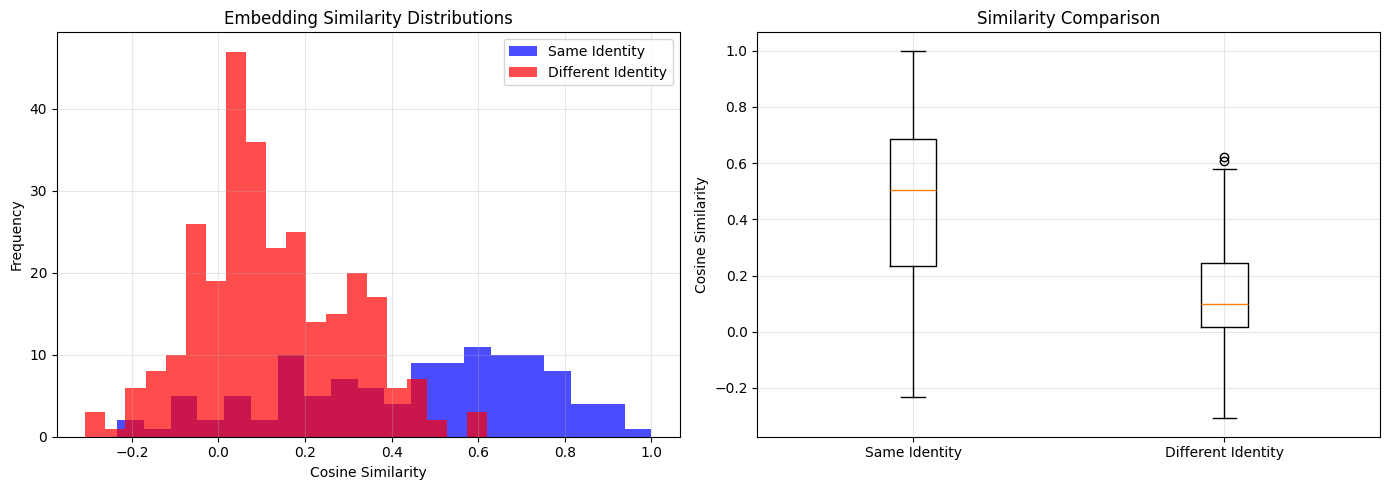

✓ Visualization complete


In [38]:
# Plot similarity distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(similarity_same_identity, bins=20, alpha=0.7, label='Same Identity', color='blue')
axes[0].hist(similarity_different_identity, bins=20, alpha=0.7, label='Different Identity', color='red')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Embedding Similarity Distributions')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
data_to_plot = [similarity_same_identity, similarity_different_identity]
axes[1].boxplot(data_to_plot, labels=['Same Identity', 'Different Identity'])
axes[1].set_ylabel('Cosine Similarity')
axes[1].set_title('Similarity Comparison')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

### 9. Sample Embedding Analysis

In [39]:
# Show sample embedding statistics
sample_identity = identities_list[0]
sample_embeddings = all_embeddings[sample_identity]

print(f"Sample Analysis: {sample_identity}")
print(f"Number of embeddings: {len(sample_embeddings)}")
print(f"Embedding shape: {sample_embeddings.shape}")
print(f"\nFirst embedding (first 10 values):")
print(f"  {sample_embeddings[0][:10]}")
print(f"\nEmbedding statistics (first 10 dims):")
print(f"  Min: {sample_embeddings[:, :10].min():.6f}")
print(f"  Max: {sample_embeddings[:, :10].max():.6f}")
print(f"  Mean: {sample_embeddings[:, :10].mean():.6f}")

# Pairwise similarity within this identity
if len(sample_embeddings) > 1:
    sim = cosine_similarity(sample_embeddings)
    print(f"\nWithin-identity similarity (cosine):")
    print(f"  Min (excl. diagonal): {sim[np.triu_indices_from(sim, k=1)].min():.4f}")
    print(f"  Max (excl. diagonal): {sim[np.triu_indices_from(sim, k=1)].max():.4f}")
    print(f"  Mean (excl. diagonal): {sim[np.triu_indices_from(sim, k=1)].mean():.4f}")

Sample Analysis: Sahil_1
Number of embeddings: 2
Embedding shape: (2, 512)

First embedding (first 10 values):
  [-0.01281822 -0.02915425 -0.07062647  0.01602382  0.03897129 -0.06743867
 -0.03532883  0.03453885  0.04347105 -0.02219227]

Embedding statistics (first 10 dims):
  Min: -0.070626
  Max: 0.043471
  Mean: -0.010455

Within-identity similarity (cosine):
  Min (excl. diagonal): 1.0000
  Max (excl. diagonal): 1.0000
  Mean (excl. diagonal): 1.0000


### 10. Summary

In [40]:
print("\n" + "="*60)
print("TASK 3: FEATURE EXTRACTOR - SUMMARY")
print("="*60)
print(f"\n✓ Model: FaceNet (VGGFace2 pretrained)")
print(f"✓ Embedding Dimension: 512")
print(f"\n📊 EXTRACTION RESULTS:")
print(f"   Total Identities: {stats['total_identities']}")
print(f"   Total Embeddings: {stats['total_embeddings']}")
print(f"   Database Size: {stats['db_size_mb']:.2f} MB")
print(f"\n✓ Database Path: {DB_PATH}")
print(f"\n📊 EMBEDDING QUALITY:")
print(f"   Same-Identity Similarity: {np.mean(similarity_same_identity):.4f} ± {np.std(similarity_same_identity):.4f}")
print(f"   Diff-Identity Similarity: {np.mean(similarity_different_identity):.4f} ± {np.std(similarity_different_identity):.4f}")
print(f"   Separation: {np.mean(similarity_same_identity) - np.mean(similarity_different_identity):.4f}")
print(f"\n" + "="*60)


TASK 3: FEATURE EXTRACTOR - SUMMARY

✓ Model: FaceNet (VGGFace2 pretrained)
✓ Embedding Dimension: 512

📊 EXTRACTION RESULTS:
   Total Identities: 21
   Total Embeddings: 80
   Database Size: 0.35 MB

✓ Database Path: C:\SAHIL\assignment\data\embeddings.db

📊 EMBEDDING QUALITY:
   Same-Identity Similarity: 0.4525 ± 0.2880
   Diff-Identity Similarity: 0.1219 ± 0.1715
   Separation: 0.3305

